## Exo 11

In [162]:
import zipfile
import numpy as np
from PIL import Image
import os
import shutil
import matplotlib.pyplot as plt

On charge le dataset d'entrainement. 

In [163]:
def load_eye_images_from_zip(zip_path):
    # Décompression du fichier ZIP
    temp_dir = "temp_images"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    
    # Filtrer les fichiers selon le pattern "eyeXX.pgm"
    images_path = sorted(
        [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.startswith("eye") and f.endswith(".pgm")]
    )
    
    image_data = []
    
    for img_path in images_path:
        with Image.open(img_path) as img:
            img = img.convert('L')  # Conversion en niveaux de gris
            wi, hi = img.size
            img_array = np.array(img).flatten()  # Aplatir l'image
            image_data.append(img_array)
    
    # Nettoyage du dossier temporaire
    shutil.rmtree(temp_dir)  # Supprime tout le dossier temporaire
    
    # Conversion en matrice numpy
    X = np.array(image_data).T  # Chaque colonne correspond à un échantillon
    return X, hi, wi

zip_file_path = "eyes.zip"
X, wi, hi = load_eye_images_from_zip(zip_file_path)
print("Nombre de dimensions (pixels) par image : ", X.shape[0])
print("Nombre d'images :", X.shape[1])
print("Stockage dans le vecteur X de taille ", X.shape)

Nombre de dimensions (pixels) par image :  875
Nombre d'images : 40
Stockage dans le vecteur X de taille  (875, 40)


On calcule l'ACP.

In [164]:
N = X.shape[1]

# Centrage des données
img_moy = (1 / N) * np.sum(X, axis=1)
m = img_moy.reshape((len(img_moy),1))
Xc = X - m

# Calcul des matrices de variances covariance 
S = (1 / (N-1)) * Xc.T @ Xc                      # Snapshot-PCA

# Diagonalisation
V, L, _ = np.linalg.svd(S, full_matrices=False) # Snapshot-PCA
U = np.dot(Xc, V)                               # Snapshot-PCA
U = U / np.linalg.norm(U, axis=0, keepdims=True)# Snapshot-PCA

On aura uniquement besoin des 15 premiers vecteurs/valeurs propres.

In [165]:
la = L[:15]
Ua = U[:, :15]

print(" Taille de la : ", la.shape)
print("Taille de Ua : ", Ua.shape)

 Taille de la :  (15,)
Taille de Ua :  (875, 15)


Q2 : On projette les images 'test1.pgm' et 'test2.pgm' sur les t axes principaux.

In [166]:
# Décompression du fichier ZIP
temp_dir = "temp_images"
with zipfile.ZipFile('eyes.zip', 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

images_path = sorted(
    [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.startswith("test") and f.endswith(".pgm")]
)

test1, test2 = [], []

for img_path in images_path:
    with Image.open(img_path) as img:
        img = img.convert('L')  # Conversion en niveaux de gris
        wi, hi = img.size
        img_array = np.array(img).flatten()  # Aplatir l'image
        if test1 == []:
            test1.append(img_array)
        else:
            test2.append(img_array)

# Nettoyage du dossier temporaire
shutil.rmtree(temp_dir)  # Supprime tout le dossier temporaire

# Conversion en matrice numpy
img_t1 = np.array(test1).T  # Chaque colonne correspond à un échantillon
img_t2 = np.array(test2).T

((-0.5, 34.5, 24.5, -0.5), (-0.5, 34.5, 24.5, -0.5))

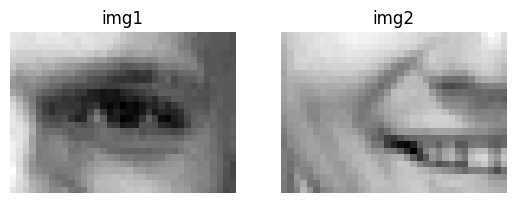

In [167]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_t1.reshape(hi, wi), cmap='gray'), axs[0].set_title('img1')
axs[1].imshow(img_t2.reshape(hi, wi), cmap='gray'), axs[1].set_title('img2')
axs[0].axis('off'), axs[1].axis('off')

In [168]:
y1 = Ua.T @ (img_t1 - m)
y2 = Ua.T @ (img_t2 - m)

In [169]:
a = np.array([[1,2,3],[4,5,6]])
print(a ** 2)

[[ 1  4  9]
 [16 25 36]]


In [170]:
# Calcul de la distance de Mahalanobis
ma1 = np.sum(((y1) ** 2 / la.reshape(15,1)))
ma2 = np.sum(((y2) ** 2 / la.reshape(15,1)))

print(" Distance MA1 : ", ma1)
print(" Distance MA2 : ", ma2)


 Distance MA1 :  5.26616493487645
 Distance MA2 :  19.111653462119502


On voit que l'image 1 est plus proche de la moyenne que l'image 2, ce qui est parfaitement logique étant donné que l'image 1 est un oeil gauche et que l'image 2 n'en est pas un. 

In [171]:
# Reconstruction des images de test.
xx1 = m + Ua @ y1;
err1= img_t1 - xx1;
EQM1 = np.linalg.norm(err1.T)/len(err1)

xx2 = m + Ua @ y2;
err2= img_t2 - xx2;
EQM2 = np.linalg.norm(err2.T)/len(err2)

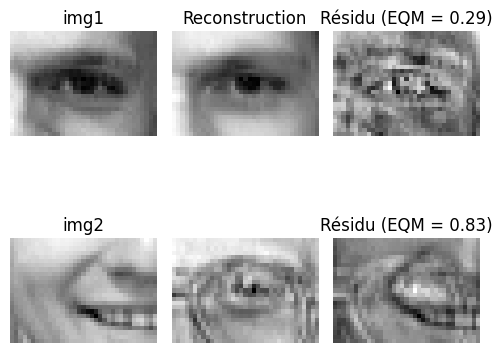

In [172]:
# Affichageaxs
fig, axs = plt.subplots(2, 3, figsize=(5,5))
for ax in axs.flatten():
    ax.set_axis_off()
axs[0, 0].imshow(img_t1.reshape(hi, wi), cmap='gray'), axs[0, 0].set_title('img1')
axs[1, 0].imshow(img_t2.reshape(hi, wi), cmap='gray'), axs[1, 0].set_title('img2')
axs[0, 1].imshow(xx1.reshape(hi, wi), cmap='gray'), axs[0, 1].set_title('Reconstruction')
axs[1, 1].imshow(xx2.reshape(hi, wi), cmap='gray')
axs[0, 2].imshow(err1.reshape(hi, wi), cmap='gray'), axs[0, 2].set_title('Résidu (EQM = {:.2f})'.format(EQM1))
axs[1, 2].imshow(err2.reshape(hi, wi), cmap='gray'), axs[1, 2].set_title('Résidu (EQM = {:.2f})'.format(EQM2))
plt.tight_layout()
plt.show()

Passons à la détection d'un oeil gauche dans une image.

In [211]:
def detection_eye(image_name):
    # Décompression du fichier ZIP
    temp_dir = "temp_images"
    with zipfile.ZipFile('eyes.zip', 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    images_path = sorted(
        [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.startswith(image_name) and f.endswith(".pgm")]
    )

    test = []

    for img_path in images_path:
        with Image.open(img_path) as img:
            img = img.convert('L')  # Conversion en niveaux de gris
            wt, ht = img.size
            img_test = np.array(img)  # Aplatir l'image

    print("image test shape : ", img_test.shape)
    print("wt = ", wt)
    print("ht = ", ht)

    hi2, wi2 = hi // 2, wi // 2  # Moitié des dimensions de l'imagette
    minMaha = np.inf
    min_i, min_j = -1, -1

    map = np.ones((ht, wt))  # Initialisation

    for y in range(hi2, ht - hi2):  # Indices centrés verticalement
        for x in range(wi2, wt - wi2):  # Indices centrés horizontalement
            # Extraction de l'imagette centrée sur (y, x)
            imagette = img_test[y-hi2:y+hi2+1, x-wi2:x+wi2+1]
            xt = imagette.flatten().reshape(-1, 1)
            yt = Ua.T @ (xt - m)  # Projection PCA
            maha = np.sum((yt**2 / la.reshape(15, 1)))  # Distance de Mahalanobis
            map[y, x] = maha

            if maha < minMaha:
                minMaha = maha
                min_i, min_j = y, x

    _, axs = plt.subplots(1, 3, figsize=(10,10))
    for ax in axs:
        ax.axis('off')
    axs[0].imshow(img_test, cmap='gray'), axs[0].set_title('Image de base')
    axs[1].imshow(img_test, cmap='gray'), axs[1].set_title('Détection oeil gauche')
    axs[1].plot(min_j, min_i, '*r')
    axs[2].imshow(np.log(map), cmap='gray'), axs[2].set_title('log(map) de Mahalanobis')
    plt.show()

image test shape :  (112, 92)
wt =  92
ht =  112


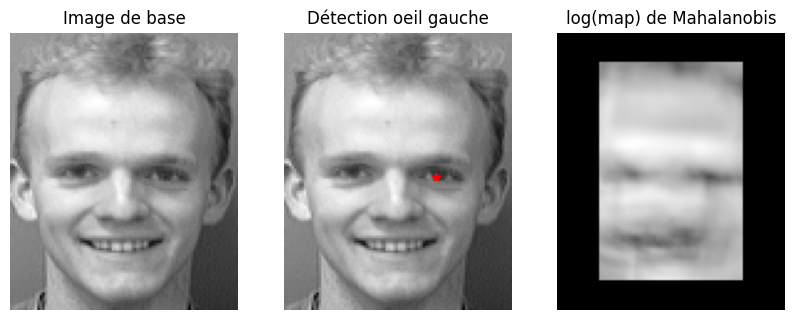

In [213]:
detection_eye("Test")

image test shape :  (150, 118)
wt =  118
ht =  150


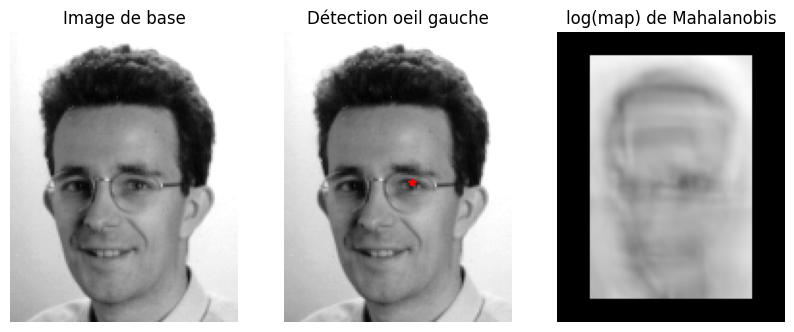

In [212]:
detection_eye("charbo")